In [1]:
# Package imports
import os
import pickle
import xml.etree.ElementTree as ET
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
class DataProcess():
    def __init__(self, args):
        self.rootDir = "./data"
        self.batch_size = args['batch_size']
        self.index_pointer = 0
        self.timesteps = args['tsteps']
        self.scale_factor = args['scale_factor']
        self.gap = args['gap']
        self.char_steps = args['tsteps']/args['tsteps_per_char']
        self.alphabet = args['alphabet']
        
        
        stroke_dir = self.rootDir + "/lineStrokes"
        ascii_dir = self.rootDir + "/ascii"
        data_file = os.path.join(self.rootDir, "strokes_training_data.cpkl")
        self.process(stroke_dir, ascii_dir, data_file)
        self.read_processed(data_file)
        self.init_batch_comp()
    
    # Read processed data from .cpkl file.
    def read_processed(self, data_file):
        # Opening in read mode
        f = open(data_file, 'rb')
        [self.raw_stroke_data, self.raw_ascii_data] = pickle.load(f)
        f.close()
        
        self.valid_stroke_data = []
        self.stroke_data = []
        self.ascii_data = []
        self.valid_ascii_data = []
        
        for i in range(len(self.raw_stroke_data)):
            data = self.raw_stroke_data[i]
            if (len(data) > self.timesteps + 2):
                # removes large gaps from the data
                data = np.minimum(data, self.gap)
                data = np.maximum(data, -self.gap)
                data[:,0:2] /= self.scale_factor
                if i%20 == 0:
                    self.valid_stroke_data.append(data)
                    self.valid_ascii_data.append(self.raw_ascii_data[i])
                else:
                    self.stroke_data.append(data)
                    self.ascii_data.append(self.raw_ascii_data[i])
        self.num_batches = int(len(self.stroke_data)/self.batch_size)
        print("Number of data examples:",  len(self.stroke_data))
        print("Batch size for dataset", self.num_batches)

        
    def init_batch_comp(self):
        self.index_perm = np.random.permutation(len(self.stroke_data))
        self.index_pointer = 0
    
    def get_next_batch(self):
        # Iterate for batch_size times to get a batch of batch_size points
        x_batch = []
        y_batch = []
        asciis = []
        for i in range(self.batch_size):
            # Pick strokes data randomly from each file
            data = self.stroke_data[self.index_perm[self.index_pointer]]
            x_batch.append(np.copy(data[:self.timesteps]))
            y_batch.append(np.copy(data[1:self.timesteps+1]))
            asciis.append(self.ascii_data[self.index_perm[self.index_pointer]])
            self.index_pointer += 1
            if(self.index_pointer >= len(self.stroke_data)):
                self.init_batch_comp()
            asciis_oh = [convert_to_one_hot(s, self.char_steps, self.alphabet) for s in asciis]    
        return x_batch, y_batch, asciis, asciis_oh         
            
        
    def process(self, rootDir, asciiDir, data_file):
        # Function that outputs linestrokes given filepath.    
        def convert_linestroke_file_to_array(filepath):
            strokeFile = ET.parse(filepath)
            root = strokeFile.getroot()
            x_min_offset = -1000000
            y_min_offset = -1000000
            y_height = 0
            for i in range(1,4):
                x_min_offset = min(x_min_offset, float(root[0][i].attrib['x']))
                y_min_offset = min(y_min_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            #TODO(add normalization)
            y_height -= y_min_offset
            x_min_offset -=100.0
            y_min_offset -=100.0
            strokeSet = root[1]
            allStrokes = []
            for i in range(len(strokeSet)):
                points = []
                for point in strokeSet[i]:
                    points.append([(float(point.attrib['x']) - x_min_offset), (float(point.attrib['y']) - y_min_offset)])
                allStrokes.append(points)
            return allStrokes    
                
    
        def get_all_files():
            rootDir = "./data"
            filePaths = []
            for dirpath, dirnames, filenames in os.walk(rootDir):
                for file in filenames:
                    filePaths.append(os.path.join(dirpath, file))
            return filePaths
        
        def get_ascii(filename, linenumber):
            with open(filename, "r") as f:
                s = f.read()
            csr = s.find("CSR")    
            s = s[csr:]
            if len(s.split("\n")) > line_number+2:
                s = s.split("\n")[line_number+2]
                return s
            else:
                return ""

        
    # Function to convert strokes to inputStrokeMatrix
        def strokes_to_input_matrix(strokes):
            strokeMatrix = []
            prev_x = 0
            prev_y = 0
            for stroke in strokes:
                for num_point in range(len(stroke)):
                    x = stroke[num_point][0] - prev_x
                    y = stroke[num_point][1] - prev_y
                    prev_x = stroke[num_point][0]
                    prev_y = stroke[num_point][1]
                    z = 0
                    if (num_point == len(stroke)-1):
                        z = 1
                    example = [x,y,z]
                    strokeMatrix.append(example)
            return strokeMatrix
        
        allFiles = get_all_files()
        strokes = []
        asciis = []
        counter = 0
        for file in allFiles:
            if file[-3:] == "xml": # and 'a0' in file:
                counter = counter + 1
                stroke = strokes_to_input_matrix(convert_linestroke_file_to_array(file))
                # Getting corresponding ascii file and line number for stroke.
                ascii_filename = file.replace("lineStrokes", "ascii")[:-7] + ".txt"
                line_number = file[-6:-4]
                line_number = int(line_number) - 1
                c = get_ascii(ascii_filename, line_number)
                if (len(c) > 10):
                    asciis.append(c)
                    strokes.append(stroke)
            # assert len(strokes) == counter    
        assert len(strokes) == len(asciis)
        f = open(data_file,"wb")
        pickle.dump([strokes, asciis], f, protocol=2)
        f.close()
        print("Saved {} lines", len(strokes))
         
        
def convert_to_one_hot(s, ascii_steps, alphabet):
    ascii_steps = int(ascii_steps)
    steplimit=3e3; s = s[:3e3] if len(s) > 3e3 else s # clip super-long strings
    seq = [alphabet.find(char) + 1 for char in s]
    if len(seq) >= ascii_steps:
        seq = seq[:ascii_steps]
    else:
        seq = seq + [0]*(ascii_steps - len(seq))
    one_hot = np.zeros((ascii_steps,len(alphabet)+1))
    one_hot[np.arange(ascii_steps),seq] = 1
    return one_hot
    
                

In [3]:
args = {}
args['batch_size'] = 3
args['tsteps'] = 100
args['scale_factor'] = 2
args['gap'] = 4
args['tsteps_per_char'] = 25
args['alphabet'] = 'abcdefghijklmnopqrstuvwxyz'
D = DataProcess(args)

Saved {} lines 949
Number of data examples: 901
Batch size for dataset 300


In [4]:
x, y , asciis, asciis_oh = D.get_next_batch()

In [5]:
print(asciis)

['ment would probably have to be for three years. ', 'Applauding on the river banks', 'yesterday: "They usually take their winter']


In [6]:
def line_plot(strokes, title):
    plt.figure(figsize=(20,2))
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

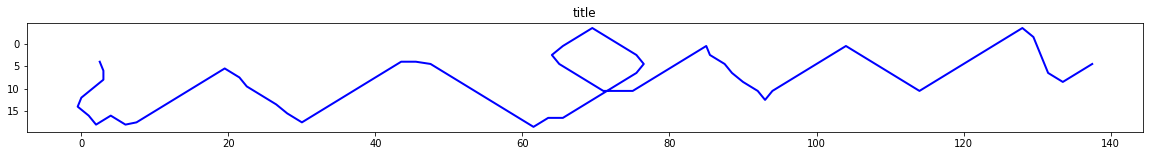

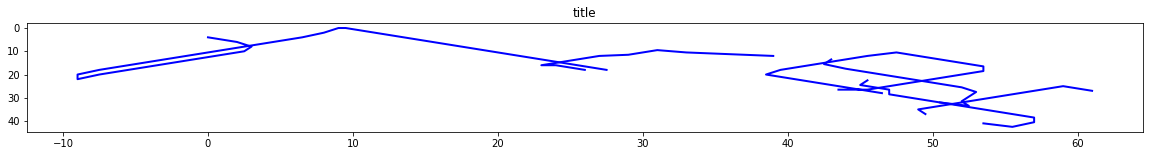

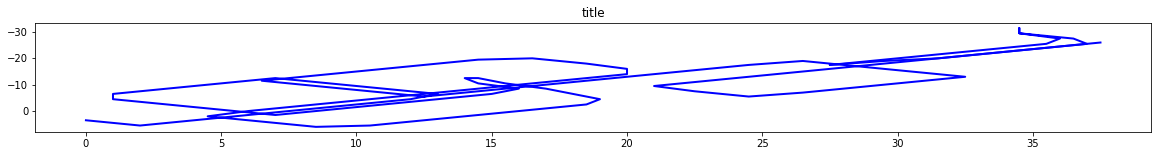

In [7]:
for i in range(args['batch_size']):
    r = x[i]
    strokes = r.copy()
    strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
    line_plot(strokes, "title")